In [1]:
# Initial imports

import os
import openai
import copy

from langchain.embeddings import OpenAIEmbeddings
from langchain.chat_models import ChatOpenAI


embeddings = OpenAIEmbeddings()
llm_name = "gpt-3.5-turbo"
llm = ChatOpenAI(model_name = llm_name, temperature = 0)

In [ ]:
# Loaders creation

from langchain.document_loaders import UnstructuredWordDocumentLoader
from langchain.document_loaders import DirectoryLoader

# Elements loader
elements_loader = DirectoryLoader(path = "docx_docs", 
                                  loader_cls = UnstructuredWordDocumentLoader,
                                  loader_kwargs = {'mode' : "elements", 'strategy': "fast"},
                                  recursive = True)

single_loader = DirectoryLoader(path = "docx_docs", 
                                loader_cls = UnstructuredWordDocumentLoader,
                                loader_kwargs = {'mode' : "single", 'strategy': "fast"},
                                recursive = True)


docs_elements = elements_loader.load()
docs_single = single_loader.load()


In [32]:
# Splitters creation

from langchain.text_splitter import NLTKTextSplitter
from langchain.text_splitter import RecursiveCharacterTextSplitter

nltk_splitter = NLTKTextSplitter()
text_splitter = RecursiveCharacterTextSplitter(chunk_size = 2000, chunk_overlap  = 0)

docs_nltk = nltk_splitter.split_documents(docs_single)
docs_recursive = text_splitter.split_documents(docs_single)


In [45]:
# Remove undeeded metadata from Elements documents

keys_to_delete = ['source', 'file_directory', 'last_modified', 'filetype', 'primary', 'text_as_html', 'emphasized_text_tags', 'emphasized_text_contents']

for doc in docs_elements:
    for key in keys_to_delete:
        if key in doc.metadata.keys():
            del doc.metadata[key]

# Removing unneeded documents
categories_to_remove = ['PageBreak', 'ListItem', 'Footer', 'Table']
docs_elements = [doc for doc in docs_elements if doc.metadata['category'] not in categories_to_remove]

# TODO: Think of what to do with headers

# TODO: Titles

# TODO: UncategorizedText - Remove short

# TODO: Table - Extract patent data, remove for artices and lectures

Text(0, 0.5, 'број карактера у документу')

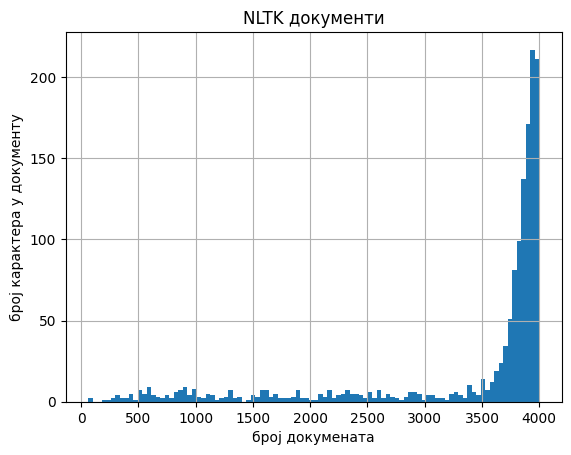

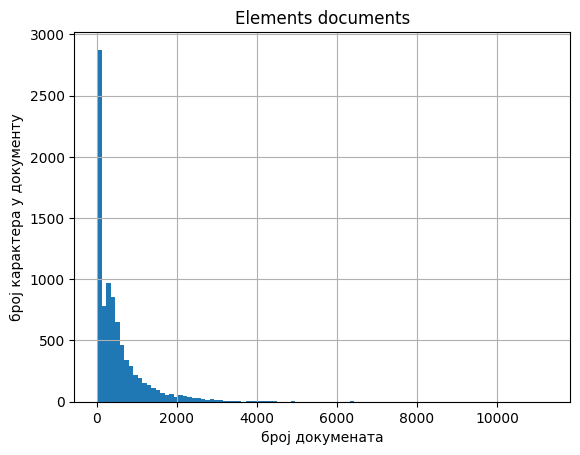

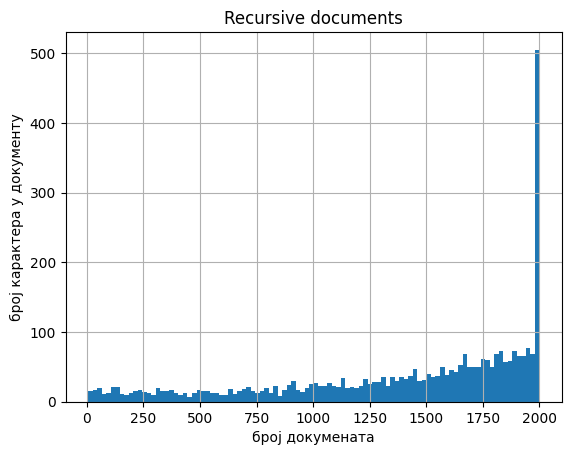

In [56]:
# Plots

from matplotlib import pyplot as plt

plt.figure(1)
plt.hist([len(d.page_content) for d in docs_nltk], bins = 100)
plt.grid()
plt.title("NLTK документи")
plt.xlabel("број докумената")
plt.ylabel("број карактера у документу")
plt.figure(2)
plt.hist([len(d.page_content) for d in docs_elements], bins = 100)
plt.grid()
plt.title("Elements documents")
plt.xlabel("број докумената")
plt.ylabel("број карактера у документу")
plt.figure(3)
plt.hist([len(d.page_content) for d in docs_recursive], bins = 100)
plt.grid()
plt.title("Recursive documents")
plt.xlabel("број докумената")
plt.ylabel("број карактера у документу")

In [49]:
# Elements Loader metadata analysis

# all = {}
# for doc in docs_elements:
#     for key, value in doc.metadata.items():
#         if key not in all.keys():
            # all[key] = [value]
#         else:
#             all[key].append(value)

In [ ]:
# Elements Loader metadata analysis

# l = [len(d.page_content) for d in docs_elements]
# max(l)
# l.index(max(l))
# print(docs_elements[l.index(max(l))].page_content)
# print(docs_elements[l.index(max(l))].metadata)

In [24]:
# Elements Loader metadata analysis

# all_metadata_keys = list(all.keys())
# print(all_metadata_keys)
# possible_categories = set(all['category'])
# print([possible_categories])

# for doc in docs_elements:
#     # if 'emphasized_text_contents' in doc.metadata.keys() and len(doc.metadata['emphasized_text_contents']) > 1:
#     if 'filename' in doc.metadata.keys() and doc.metadata['filename'] == 'Experiments with Alternate Currents of High Potential and High Frequency.docx':    
#         # print(doc.metadata['emphasized_text_contents'])
#         print(doc.metadata)


In [52]:
# Metadata parsing

import json

metadata_dict = {}
metadatas = json.load(open('metadata.json'))

ascii_replace_dict = {'â€™': '’', 'â€œ': '“', 'â€': '”'}
def replace_non_ascii(s):
    for pair_k, pair_v in ascii_replace_dict.items():
        s = s.replace(pair_k, pair_v)
    return s

for metadata in metadatas[2]['data']:
    if metadata['id'] in ['228', '413']:
        # These are duplicates, not needed
        continue
    key = ''.join(metadata['file_url'].split('/')[-1].rsplit('.', 1)[:-1])

    # Repalce non-ascii characters in key
    key = replace_non_ascii(key)
    
    # Make sure that there are no duplicate entries for the same document type
    if (key in metadata_dict.keys() and metadata['type'] == metadata_dict[key]['type']):
        print(key)
        print(metadata['id'])
    assert not (key in metadata_dict.keys() and metadata['type'] == metadata_dict[key]['type'])
    metadata_dict[key] = {key: value for key, value in metadata.items() if value is not None}
    
    # Replace non-ascii characters in file url
    del metadata_dict[key]['file_url']
    for m_key, m_value in metadata_dict.items():
        if m_value is None:
            del metadata_dict[m_key]

In [53]:
# Adding metadata

for doc in docs_elements:
    assert doc.metadata['filename'][:-5] in metadata_dict.keys()
    doc.metadata.update(metadata_dict[doc.metadata['filename'][:-5]])

In [54]:
# Vectorstore creation

from langchain.vectorstores import Chroma

vectorstore = Chroma.from_documents(
    documents = docs_elements,
    embedding = embeddings,
    persist_directory="./chroma_db"
)

In [ ]:
# Vectorstore loading

vectorstore = Chroma(persist_directory="./chroma_db", embedding_function = embeddings)

In [56]:
from langchain.chains.query_constructor.base import AttributeInfo
from langchain.retrievers.self_query.base import SelfQueryRetriever


# TODO: add new metadata
metadata_field_info = [
    AttributeInfo(
        name="document_name",
        description="Name of the source document",
        type="string",
    ),
    AttributeInfo(
        name="id",
        description="Document ID",
        type="string",
    ),
    AttributeInfo(
        name="title",
        description="Title of the document",
        type="string",
    ),
    AttributeInfo(
        name="date",
        description="When the document was created",
        type="string",
    ),
    AttributeInfo(
        name="register_num",
        description="Patent registration number",
        type="string",
    ),
    AttributeInfo(
        name="source",
        description="Source of the document",
        type="string",
    ),
    AttributeInfo(
        name="type",
        description="Type of the document - options are lecture, article, patent",
        type="string",
    )
]

document_content_description = "Document content"

retriever = SelfQueryRetriever.from_llm(
    llm = llm, 
    vectorstore = vectorstore,
    document_contents = document_content_description,
    metadata_field_info = metadata_field_info, 
    verbose=True
)

In [57]:
docs = retriever.get_relevant_documents("What lectures did Nikola Tesla give")

/home/jaksa/miniconda3/lib/python3.10/site-packages/langchain/chains/llm.py:278: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(


query='Nikola Tesla' filter=Comparison(comparator=<Comparator.EQ: 'eq'>, attribute='type', value='lecture') limit=None


In [58]:
[d.metadata['filename'] for d in docs]

['On Light and Other High Frequency Phenomena.docx',
 'Experiments With Alternate Currents of High Potential and High Frequency (lecture).docx',
 'A New System of Alternate Current Motors and Transformers (lecture).docx',
 '8 High Frequency Oscillators for Electro-Therapeutic and Other Purposes (lecture).docx']

In [59]:
# Basic Retriever example

from langchain.chains import RetrievalQA

question = "How many poles shoul my electromotor have, and what should I do if I have the wrong number?"
qa_chain = RetrievalQA.from_chain_type(llm = llm, retriever = retriever)
print(qa_chain({"query": question}))

query='electromotor poles' filter=None limit=None
{'query': 'How many poles shoul my electromotor have, and what should I do if I have the wrong number?', 'result': 'Based on the given context, the number of poles in an electromotor can vary. The motor X has eight poles, the motor Y has six poles, and the motor Z has four poles. The number of poles determines the speed of the motor. If you have the wrong number of poles, you can change the electrical connections to achieve the desired speed. For example, in motor X, you can alternate between two like and two opposite poles to effectively reduce the number of poles by half and double the speed of the motor.'}


In [ ]:
# Retriever with memory example

from langchain.memory import ConversationBufferMemory
from langchain.chains import ConversationalRetrievalChain

memory = ConversationBufferMemory(memory_key = "chat_history", return_messages = True)
retriever = vectorstore.as_retriever()
qa = ConversationalRetrievalChain.from_llm(llm = llm, retriever = retriever, memory = memory)
question = input()
print(f"Question: {question}")
print(f"Answer: {qa({'question': question})['answer']}")
question = input()
print(f"Question: {question}")
print(f"Answer: {qa({'question': question})['answer']}")